Построим трансформер для задачи **question answering**. Трансформер будет работать по принципу чат-бота: принимать на вход вопрос, и генерировать ответ на этот вопрос. В качестве датасета используем русско-язычный диалог от [Денчика с HuggingFace](https://huggingface.co/datasets/Den4ikAI/russian_dialogues).

Датасет русских диалогов собранных с Telegram чатов. Диалоги имеют разметку по релевантности. Также были сгенерированы негативные примеры с помощью перемешивания похожих ответов.

Количество диалогов - 2 миллиона

## Установка и импорт необходимых библиотек

In [ ]:
# Установим свежую версию TensorFlow для поддержки слоя `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow
!pip install datasets fireducks

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libcudnn8
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 9

In [ ]:
# Логирование для отладки
import logging

# Замеры времени выполнения
import time

# Линейная алгебра
import numpy as np

# Pandas
import fireducks.pandas as pd

# Вывод графиков
import matplotlib.pyplot as plt

# Фреймворк Tensorflow
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_text as text

# Регулярные выражения
import re

# Файловая система
import pathlib

# Токенизатор
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
from typing import List, Union, Dict
from transformers import BertTokenizer

# Загрузка датасета
from datasets import load_dataset

# Токенизатор
from tokenizers import BertWordPieceTokenizer
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

# Итератор
import itertools

# Отключим мешаюшие предупреждения
import warnings
warnings.filterwarnings("ignore")

## Загрузка датасета

In [ ]:
dataset = load_dataset('Den4ikAI/russian_dialogues', split='train', )

In [ ]:
# Преобразуем наш датасет в DataFrame
df = pd.DataFrame(dataset)

## Предобработка датасета

In [ ]:
# Удаляем все строки с relevance = 0
df = df[df['relevance'] != 0]

In [ ]:
# Удаляем столбец relevance
df = df.drop(columns=['relevance'])

In [ ]:
# Удаляем N/A
df = df.dropna()

In [ ]:
# Скоращаем до 100к примеров
df = df.sample(n=100000, random_state=42)

In [ ]:
# Посмотрим на результат
df

question 
 answer 
 
 
 
 
 1533474 
 кто летал на турецких авиалиниях? расскажите к... 
 очень хорошие авиалинии. летала не раз. 
 
 
 892181 
 как забрать файлы с внутренней памяти телефона? 
 или файловый менеджер поставь и перенеси все ч... 
 
 
 1187999 
 психолог должен быть сильным, как не податься ... 
 абстрагироваться от вопросов 
 
 
 1421896 
 жена сказала. мне так грусно. давай заведем вт... 
 если в семье только один ноутбук, он вырастет ... 
 
 
 910722 
 какая ты скромная 
 спасибо, вы просто супер 
 
 
 ... 
 ... 
 ... 
 
 
 1768203 
 вапрос для всех а секс может интересно надоесть? 
 если партнерша одна то может. рутина. мы ж пол... 
 
 
 704964 
 теперь можно паленым виндом пользоватся? 
 кидаешь кряк отключаешь все обновления и польз... 
 
 
 2292283 
 те, кто обучается в аспирантуре, обязательно д... 
 это уж как в вашем вузе заведено. я в свое вре... 
 
 
 215512 
 пока ничья. кто победит? 
 думаю что матч может закончится вничью. это бу... 
 
 
 1670470 
 верите в конец света? 
 верю, что когда-нибудь он наступит 
 
 
 
 100000 rows x 2 columns

In [ ]:
# Разделяем на обучающую и валидационную выборки
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

In [ ]:
print('Размер обучающей выборки: ', len(train_df))
print('Размер валидационной выборки: ', len(val_df))

Размер обучающей выборки:  90000
Размер валидационной выборки:  10000


In [ ]:
# Преобразование DataFrame в TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_df['question'].values, train_df['answer'].values)
)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_df['question'].values, val_df['answer'].values)
)

Посмотрим на примеры записей:

In [ ]:
for questions, answers in train_dataset.batch(3).take(1):
  print('Примеры вопросов:')
  print()
  for q in questions.numpy():
    print(q.decode('utf-8'))
  print()

  print('Примеры ответов:')
  print()
  for a in answers.numpy():
    print(a.decode('utf-8'))

Примеры вопросов:

от какого подарочка трудно отказаться?
а ты автомотовец, тоже советуешь купить подержаное авто вместо нового?
а что вы всегда делаете, исключительно с загадочным лицом?

Примеры ответов:

от подарка любимого человека. каким бы подарок ни был.
лучшая машина новая
роюсь в карманах спящего мужа.


## Токенизация

### Создаем свой токенайзер на базе BERT

#### Создаем словари слов

In [ ]:
VOCAB_SIZE = 8000
# Параметры токенизатора (lower_case - приводим к нижнему регистру)
bert_tokenizer_params=dict(lower_case=True)

# Определяем токены, с которыми работает токенизатор
# [START] - начало строки
# [END]   - конец строки
# [UNK]   - неизвестное слово
# [PAD]   - используется для выравнивания длин всех предложений
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    # Желаемый размер словаря
    vocab_size = VOCAB_SIZE,
    # Токены включаемые в словарь
    reserved_tokens=reserved_tokens,
    # Аргументы для `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Аргументы для `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={}, # не используем, но определяем чтобы не было ошибок
)

Т.к. мы работаем с задачей  QA (вопрос-ответ на одном языке), то можно использовать общий словарь:

In [ ]:
# Объединение текста из столбцов question и answer
text_corpus = train_dataset.map(lambda q, a: a + q)

In [ ]:
# Проверяем размер корпуса
print(f"Количество текста в корпусе: {len(text_corpus)}")

Количество текста в корпусе: 90000


Создаем словарь из датасета (засечем время выполнения с помощью `%%time`):

In [ ]:
%%time
vocab = bert_vocab.bert_vocab_from_dataset(
    text_corpus.batch(1000).prefetch(2),
    **bert_vocab_args
)

CPU times: user 15min 18s, sys: 9.97 s, total: 15min 28s
Wall time: 15min 16s


Посмотрим на фрагменты словаря:

In [ ]:
print(vocab[:10])
print(vocab[100:110])
print(vocab[1000:1010])
print(vocab[-10:])

NameError: name 'vocab' is not defined

Будем сохранять словарь в файл:

In [ ]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [ ]:
write_vocab_file('vocab.txt', vocab)

NameError: name 'vocab' is not defined

Проверим, что на диске создан текстовый файл:

In [ ]:
!ls *.txt

vocab.txt


#### Загрузка токенайзера из файла

In [ ]:
tokenizer = text.BertTokenizer('vocab.txt', **bert_tokenizer_params)

In [ ]:
print('Отберем строки для примера:')
for questions, answers in train_dataset.batch(3).take(1):
  for ex in answers.numpy():
    print(ex.decode('utf-8'))

Отберем строки для примера:
от подарка любимого человека. каким бы подарок ни был.
лучшая машина новая
роюсь в карманах спящего мужа.


Прогоним примеры через `BertTokenizer.tokenize` метод. Он вернет нам объект `tf.RaggedTensor` с осями `(batch, word, word-piece)`:

In [ ]:
# Токенизируем примеры и получаем тензор формы (batch, word, word-piece)
token_batch = tokenizer.tokenize(answers)
# Объединяем оси word и word-piece и получаем тензор формы (batch, tokens)
token_batch = token_batch.merge_dims(-2,-1)

print('Токенизируем отобранные строки:')
for ex in token_batch.to_list():
  print(ex)

Токенизируем отобранные строки:
[84, 232, 3164, 1174, 196, 7, 421, 99, 904, 182, 255, 7]
[2154, 1197, 2432]
[52, 3752, 144, 39, 4508, 4692, 2548, 53, 389, 108, 1229, 669, 7]


Для того, чтобы повторно собрать слова из извлеченных токенов, необходимо использовать `BertTokenizer.detokenize` метод:

In [ ]:
words = tokenizer.detokenize(token_batch)
print('Проверим обратное преобразование:')

# Объединение и декодирование
joined_text = tf.strings.reduce_join(words, separator=' ', axis=-1)
decoded_texts = [text.numpy().decode('utf-8') for text in joined_text]

# Вывод результатов
for text in decoded_texts:
    print(text)

Проверим обратное преобразование:
от подарка любимого человека . каким бы подарок ни был .
лучшая машина новая
роюсь в карманах спящего мужа .


#### Длина фраз в датасете

Нам необходимо оценить как распределяются токены по примерам:

In [ ]:
lengths = []

for q_examples, a_examples in train_dataset.batch(1024):
  q_tokens = tokenizer.tokenize(q_examples)
  lengths.append(q_tokens.row_lengths())

  a_tokens = tokenizer.tokenize(a_examples)
  lengths.append(a_tokens.row_lengths())

И отобразим на графике:

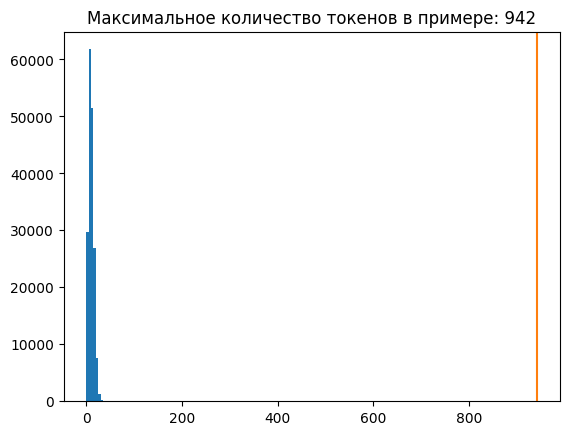

In [ ]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Максимальное количество токенов в примере: {max_length}');

Исходя из графика выбираем максимальную длину фраз:

In [ ]:
MAX_TOKENS=32

#### Добавление токенов [START] и [END]

С помощью `reserved_tokens` мы уже включили токены `[START]` и `[END]` в словарь. Теперь необходимо добавить токены во все фразы, они имеют одинаковые индексы для обоих языков:

In [ ]:
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)

Посмотрим на пример с добавленными токенами:

In [ ]:
words = tokenizer.detokenize(add_start_end(token_batch))
tf.strings.reduce_join(words, separator=' ', axis=-1)

# Объединение и декодирование
joined_text = tf.strings.reduce_join(words, separator=' ', axis=-1)
decoded_texts = [text.numpy().decode('utf-8') for text in joined_text]

# Вывод результатов
for text in decoded_texts:
    print(text)

[START] от подарка любимого человека . каким бы подарок ни был . [END]
[START] лучшая машина новая [END]
[START] роюсь в карманах спящего мужа . [END]


### Очистка текста при детокенизации

Мы хотим, чтобы при детокенизации мы сразу получали строку, а не тензоры, а также чтобы выходные строки не содержали зарезервированные токены. Для этого напишем вспомогательную функцию:

In [ ]:
def cleanup_text(reserved_tokens, token_txt):
  # Удаление токенов, кроме "[UNK]".
  # Поиск зарезервированных токенов кроме [UNK]
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  # "Плохие" токены для регулярки объединяем знаком ИЛИ (|)
  bad_token_re = "|".join(bad_tokens)

  # Ищем в строке регулярку
  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  # Отсеиваем из исходной строки все найденные включения "плохих" токенов
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Сцепление строк.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

Заново отберем строки, так как en_examples был переопределен:

In [ ]:
print('Отберем строки для примера:')
for q_examples, a_examples in train_dataset.batch(3).take(1):
    for ex in a_examples:
        # Декодируем каждый пример
        decoded_ex = ex.numpy().decode('utf-8')
        print(decoded_ex)

Отберем строки для примера:
от подарка любимого человека. каким бы подарок ни был.
лучшая машина новая
роюсь в карманах спящего мужа.


In [ ]:
# Декодируем весь батч
decoded_a_examples = [ex.numpy().decode('utf-8') for ex in a_examples]
print(decoded_a_examples)

['от подарка любимого человека. каким бы подарок ни был.', 'лучшая машина новая', 'роюсь в карманах спящего мужа.']


А это уже вид после очистки:

In [ ]:
result = cleanup_text(reserved_tokens, words)
# Преобразование массива байтов в читаемые строки
decoded_result = [item.decode('utf-8') for item in result.numpy()]
print("Декодированный результат:", decoded_result)

Декодированный результат: ['от подарка любимого человека . каким бы подарок ни был .', 'лучшая машина новая', 'роюсь в карманах спящего мужа .']


#### Создание кастомного токенизатора

Создадим свой кастомный класс `CustomTokenizer` на базе `text.BertTokenizer`, с дополнительной пользовательской логикой, и `@tf.function` обертками, необходимыми для экспорта.

In [ ]:
import tensorflow as tf
import tensorflow_text as text
import pathlib

# Класс токенизатора
class CustomTokenizer(tf.Module):
    def __init__(self, reserved_tokens, vocab_path):
        # Зарезервированные токены
        self._reserved_tokens = reserved_tokens
        # Путь к файлу словаря
        self._vocab_path = tf.saved_model.Asset(vocab_path)

        # Читаем словарь из файла
        vocab = pathlib.Path(vocab_path).read_text().splitlines()
        self.vocab = tf.constant(vocab)  # Используем tf.constant вместо tf.Variable

        # Инициализируем токенизатор BERT
        self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)

        # Создаем сигнатуры для методов
        self.tokenize.get_concrete_function(
            tf.TensorSpec(shape=[None], dtype=tf.string))

        self.detokenize.get_concrete_function(
            tf.TensorSpec(shape=[None, None], dtype=tf.int64))

        self.lookup.get_concrete_function(
            tf.TensorSpec(shape=[None, None], dtype=tf.int64))

        self.get_vocab_size.get_concrete_function()
        self.get_vocab_path.get_concrete_function()
        self.get_reserved_tokens.get_concrete_function()

    @tf.function
    def tokenize(self, strings):
        enc = self.tokenizer.tokenize(strings)
        enc = enc.merge_dims(-2, -1)
        enc = add_start_end(enc)
        return enc

    @tf.function
    def detokenize(self, tokenized):
        words = self.tokenizer.detokenize(tokenized)
        return cleanup_text(self._reserved_tokens, words)

    @tf.function
    def lookup(self, token_ids):
        return tf.gather(self.vocab, token_ids)

    @tf.function
    def get_vocab_size(self):
        return tf.shape(self.vocab)[0]

    @tf.function
    def get_vocab_path(self):
        return self._vocab_path

    @tf.function
    def get_reserved_tokens(self):
        return tf.constant(self._reserved_tokens)

In [ ]:
tokenizers = tf.Module()
tokenizers = CustomTokenizer(reserved_tokens, 'vocab.txt')

А модуль сохранить и обращаться к нему, когда он нам понадобится.

In [ ]:
model_name = 'converter'
tf.saved_model.save(tokenizers, model_name)

Теперь работать с токенизатором стало намного удобнее.

Пример токенизации:

In [ ]:
encoded = tokenizers.tokenize(a_examples)

for row in encoded.to_list():
  print(row)

[2, 84, 232, 3164, 1174, 196, 7, 421, 99, 904, 182, 255, 7, 3]
[2, 2154, 1197, 2432, 3]
[2, 52, 3752, 144, 39, 4508, 4692, 2548, 53, 389, 108, 1229, 669, 7, 3]


Обратите внимание на токен 2 в начале строки и 3 в конце. К нашим строкам уже добавляются токены `[START]` и `[END]`.

Проведем обратную детокенизацию:

In [ ]:
round_trip = tokenizers.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

от подарка любимого человека . каким бы подарок ни был .
лучшая машина новая
роюсь в карманах спящего мужа .


Метод `lookup` преобразует идентификаторы токенов в текстовое представление токенов:

In [ ]:
tokens = tokenizers.lookup(encoded)
# Декодирование байтовых строк внутри tf.RaggedTensor
decoded_tokens = [[token.decode('utf-8') for token in row.numpy()] for row in tokens]
print(decoded_tokens)

[['[START]', 'от', 'под', '##арка', 'любимого', 'человека', '.', 'каким', 'бы', 'подарок', 'ни', 'был', '.', '[END]'], ['[START]', 'лучшая', 'машина', 'новая', '[END]'], ['[START]', 'р', '##ою', '##сь', 'в', 'ка', '##рма', '##нах', 'с', '##п', '##я', '##щего', 'мужа', '.', '[END]']]


## Подготовка датасета, предобработка данных

Определим вспомогательную функцию `prepare_batch` для подготовки датасета к виду, пригодному для использования в методе обучения `fit`:

In [ ]:
def prepare_batch(questions, answers):
    questions = tokenizers.tokenize(questions)   # Токенизируем данные
    questions = questions[:, :MAX_TOKENS]           # Выравнивание данных по MAX_TOKENS.
    questions = questions.to_tensor()               # Преобразуем в тензор с равномерными измерениями

    answers = tokenizers.tokenize(answers)
    answers = answers[:, :(MAX_TOKENS+1)]
    answers_inputs = answers[:, :-1].to_tensor()  # Удаляем [END] токены (вход декодировщика)
    answers_labels = answers[:, 1:].to_tensor()   # Удаляем [START] токены (выход декодировщика)

    return (questions, answers_inputs), answers_labels

Данная функция принимает пакеты текста в качестве входных данных и преобразует их в формат, подходящий для обучения, а именно:
* разбивает данные на отдельные пакеты.
* обрезает каждый из них, чтобы он был не длиннее MAX_TOKENS.
* разбивает целевые (английские) токены на входные данные и метки, а также сдвигает их на один шаг, так чтобы целевые токены были смещены на один токен от входных токенов.
* преобразует RaggedTensors (срезы измерений могут иметь разную длину) в тензоры с равномерными измерениями.
* возвращает пару (входные данные, метки).

Определим константы для формирования пакетов:

In [ ]:
# Размер буфера в памяти при подготовке датасета
BUFFER_SIZE = 20000

# Размер пакета
BATCH_SIZE = 128

Прогоним фразы через подготовленную функцию и сформируем пакеты:

In [ ]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)                     # перемешиваем данные
      .batch(BATCH_SIZE)                        # делим датасет на пакеты
      .map(prepare_batch, tf.data.AUTOTUNE)     # применим функцию prepare_batch
      .prefetch(buffer_size=tf.data.AUTOTUNE))  # prefetch используется для разделения времени, когда данные подготавливаются и потребляются, что ускоряет обучение сети

 </section>

Создаем пакеты для обучающей и валидационной выборок:

In [ ]:
train_batches = make_batches(train_dataset)
val_batches = make_batches(val_dataset)

Выведем форму одного пакета:

In [ ]:
for (q, a), a_labels in train_batches.take(1):
  break

print(q.shape)
print(a.shape)
print(a_labels.shape)

(128, 32)
(128, 32)
(128, 32)


## Архитектура модели

Соберем модель по частям. Начнем с эмбеддингов и позиционного кодирования.

### Позиционное кодирование и эмбеддинги

In [ ]:
# length - порядковый номер слова в фразе
# depth - размер пространства эмбеддинга
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # форма (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # форма (1, depth)

  angle_rates = 1 / (10000**depths)         # форма (1, depth)
  angle_rads = positions * angle_rates      # форма (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)  # указываем тип возвращаемых данных

Протестируем работу функции:

In [ ]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Прверим форму
print(pos_encoding.shape)

(2048, 512)


Создадим слой `Position Embedding`

In [ ]:
# Наследуем класс от tf.keras.layers.Layer
# Теперь наш слой тоже является классом Keras
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) # эмбеддинг
    self.pos_encoding = positional_encoding(length=2048, depth=d_model) # позиционное кодирование

  # Данный метод возвращает маску эмбеддинга
  # Так как вектора выравниваются до одной длины с помощью pad_sequences,
  # то метод вернет True для ненулевых токенов, и False для нулевых токенов

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)

    # Этот коэффициент задает относительный масштаб встраивания и позиционного кодирования
    # C этим параметром можно и нужно играться!
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

Посмотрим как работает слой:

In [ ]:
embed_q = PositionalEmbedding(vocab_size=tokenizers.get_vocab_size().numpy(), d_model=512)
embed_a = PositionalEmbedding(vocab_size=tokenizers.get_vocab_size().numpy(), d_model=512)

q_emb = embed_q(q)
a_emb = embed_a(a)

Выведем маску:

In [ ]:
a_emb._keras_mask

<tf.Tensor: shape=(128, 32), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### Нормализация и остаточная связь (объединение)

### Базовый класс внимания

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

### Encoder-Decoder Attention

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    # Пропускаем сигнал через многоголовое внимание
    attn_output, attn_scores = self.mha(
        query=x,                        # запрос
        key=context,                    # ключ
        value=context,                  # значение
        return_attention_scores=True)   # возвращаем оценки внимания

    # Запоминаем оценки на будущее
    self.last_attn_scores = attn_scores

    # Добавляем остаточную связь и нормализацию
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

Посмотрим на пример прохождения сигнала через слой:

In [ ]:
# При инициализации через базовый класс передаем в слой tf.keras.layers.MultiHeadAttention
# параметры num_heads - число голов, key_dim - размерность ключа
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(q_emb.shape)
print(a_emb.shape)
print(sample_ca(a_emb, q_emb).shape)

(128, 32, 512)
(128, 32, 512)
(128, 32, 512)


### Слой GlobalSelfAttention

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    # Пропускаем сигнал через многоголовое внимание
    attn_output = self.mha(
        query=x,  # запрос
        value=x,  # ключ
        key=x)    # значение

    # Добавляем остаточную связь и нормализацию
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

Пропустим сигнал через слой `GlobalSelfAttention`  с двумя головами и посмотрим на размерности, лишний раз убедившись, что выходная последовательность соответствует `query`. Такие проверки на стадии разработки помогают избежать ошибок во время сбора модели целиком.

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(q_emb.shape)
print(sample_gsa(q_emb).shape)

(128, 32, 512)
(128, 32, 512)


### CausalSelfAttention слой (с причинно-следственной связью)

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)  # отличается от GlobalSelfAttention одним аргументом
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

Протестируем, что слой работает правильно:

In [ ]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(a_emb.shape)
print(sample_csa(a_emb).shape)

(128, 32, 512)
(128, 32, 512)


Выходные данные для ранних элементов последовательности не зависят от более поздних элементов, поэтому не должно иметь значения, обрезаете ли вы элементы до или после нанесения слоя (должно получиться очень маленькое число):

In [ ]:
out1 = sample_csa(embed_a(a[:, :3]))
out2 = sample_csa(embed_a(a))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

np.float32(0.14335728)

### Сеть прямого распространения (feed forward network)

Сеть состоит из двух слоев `Dense` (Relu и линейной активации), а также слоем регуляризации `Dropout`. Как и в случае со слоями внимания, добавляем также остаточную связь и нормализацию:

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

Здесь `dff` - размерность первого `Dense` слоя, `d_model` - размерность эмбеддингов и нашего второго `Dense` слоя (стараемся максимально близко по параметрам соответствовать оригинальной статье), `dropout_rate` - параметр регуляризации.

Протестируем слой, и убедимся, что на выходе он будет иметь ту же форму, что и на входе:

In [ ]:
sample_ffn = FeedForward(512, 2048)

print(a_emb.shape)
print(sample_ffn(a_emb).shape)

(128, 32, 512)
(128, 32, 512)


## Собираем сеть целиком

### Слой кодировщика

Определим один слой кодировщика `EncoderLayer`:

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,  # число голов
        key_dim=d_model,      # размерность ключа
        dropout=dropout_rate) # уровень регуляризации

    self.ffn = FeedForward(d_model, dff) # число нейронов во втором и первом Dense слое, соответственно

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

И сразу выполним тест:

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(q_emb.shape)
print(sample_encoder_layer(q_emb).shape)

(128, 32, 512)
(128, 32, 512)


### Блок кодировщика

Блок кодировщика состоит из входного `PositionalEmbedding` слоя на входе и стека из `EncoderLayer` слоев:

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    # Инициируем переменные внутри класса
    self.d_model = d_model
    self.num_layers = num_layers

    # Создаем объект класса позиционного кодирования
    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    # Создаем объект класса для слоя кодировщика
    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    # Создаем объект класса для слоя регуляризации
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # Форма x токена: (batch, seq_len)
    # Прогоняем последовательность токенов через слой позиционного кодирования
    x = self.pos_embedding(x)  # форма на выходе (batch_size, seq_len, d_model)

    # Прогоняем последовательность токенов через слой регуляризации
    x = self.dropout(x)

    # Прогоняем последовательность токенов через num_layers слоев кодировщика
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # форма на выходе (batch_size, seq_len, d_model)

Протестируем кодировщик:

In [ ]:
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=VOCAB_SIZE)

sample_encoder_output = sample_encoder(q, training=False)

print(q.shape)
print(sample_encoder_output.shape)  # форма на выходе (batch_size, input_seq_len, d_model)

(128, 32)
(128, 32, 512)


### Слой декодировщика

Стек декодировщиков немного сложнее, поскольку каждый слой декодировщика содержит слой внимания с причинно-следственной связью `CausalSelfAttention`, кросс-внимания `CrossAttention` и `FeedForward` слой:

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    # Слой внимания с причинно-следственной связью
    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    # Слой с кросс-вниманием
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    # Слой прямого распространения
    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    # Пропускаем последовательность токенов через:
    # Каузальный слой внимания
    x = self.causal_self_attention(x=x)
    # Слой кросс-внимания и контекстным вектором из кодировщика
    x = self.cross_attention(x=x, context=context)

    # Запомним оценки внимания на будущее
    self.last_attn_scores = self.cross_attention.last_attn_scores
    # Через слой прямого распространения
    x = self.ffn(x)  # Форма `(batch_size, seq_len, d_model)`.
    return x

Протестируем наш слой декодировщика:

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=a_emb, context=q_emb)

print(a_emb.shape)
print(q_emb.shape)
print(sample_decoder_layer_output.shape)  # Форма `(batch_size, seq_len, d_model)`

(128, 32, 512)
(128, 32, 512)
(128, 32, 512)


### Блок декодировщика

Определим декодировщик целиком как наследник класса слоя keras `tf.keras.layers.Layer`:

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    # Инициируем переменные внутри класса
    self.d_model = d_model
    self.num_layers = num_layers

    # Создаем объект класса позиционного кодирования
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    # Создаем объект класса для слоя регуляризации
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

    # Создаем сразу стек слоев декодировщиков с помощью генератора списков по числу слоев
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    # Сбрасываем оценки внимания
    self.last_attn_scores = None

  def call(self, x, context):
    # Подаем на вход последовательность токенов x формой (batch, target_seq_len)

    # Пропускаем через слой позиционного кодирования (и конечно же эмбеддинг)
    x = self.pos_embedding(x)  # форма на выходе (batch_size, target_seq_len, d_model)

    # Регуляризация
    x = self.dropout(x)

    # Прогоняем через num_layers слоев декодировщиков
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    # Сохраняем оценки внимания из последнего слоя
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # Форма x на выходе (batch_size, target_seq_len, d_model)
    return x

Протестируем декодировщик целиком:

In [ ]:
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=a,
    context=q_emb)

print(a.shape)
print(q_emb.shape)
print(output.shape)

(128, 32)
(128, 32, 512)
(128, 32, 512)


In [ ]:
sample_decoder.last_attn_scores.shape # форма оценок внимания на выходе из декодировщика (batch, heads, target_seq, input_seq)

TensorShape([128, 8, 32, 32])

## Трансформер

Таким образом, мы написали классы `Encoder` и `Decoder`. Чтобы получить модель `Transformer` целиком, нам необходимо их соединить и добавить конечный `Dense` слой, который преобразует результирующий вектор в каждой позиции в вероятности выходных токенов.

Выходные данные декодера являются входными данными для этого конечного слоя.

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    # Кодировщик
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)
    # Декодировщик
    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)
    # Конечный слой
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # Чтобы использовать метод `.fit` для обучения модели, необходимо передать
    # все входные данные в первом аргументе
    context, x  = inputs

    # Передаем контекст в кодировщик
    context = self.encoder(context)  # форма выходных данных (batch_size, context_len, d_model)

    # Передаем контекст и целевой вектор в декодировщик
    x = self.decoder(x, context)  # форма выходных данных (batch_size, target_len, d_model)

    # Прогоняем выходные данные через финальный слой
    logits = self.final_layer(x)  # форма выходных данных (batch_size, target_len, target_vocab_size)

    try:
      # После прохождения данных через все слои необходимо удалить
      # маску, чтобы она не масштабировала, потери и метрики
      # Обработчик ошибок позволяет избежать исключений при повторной попытке удаления
      del logits._keras_mask
    except AttributeError: # отлавливаем ошибку отсутствия аттрибута
      pass

    # Возвращаем наши логиты
    return logits

## Обучение модели

Начнем с определения параметров для нашего трансформера. Чтобы этот пример был небольшим и относительно быстрым, количество слоев (`num_layers`), размерность эмбеддингов (`d_model`), количество голов (`num_heads`) и размерность слоя прямой связи (`dff`) мы уменьшим.

В базовой модели (оригинальная статья) использовались `num_layers=6`, `d_model=512`, `dff=2048`, `num_heads=8`.

In [ ]:
num_layers = 2
d_model = 128
dff = 256
num_heads = 4
dropout_rate = 0.1

EPOCHS = 3

Соберем трансформер с заданными параметрами:

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

Протестируем трансформер:

In [ ]:
output = transformer((q, a))

print(a.shape)
print(q.shape)
print(output.shape)

(128, 32)
(128, 32)
(128, 32, 7730)


Протестируем оценки внимания на выходе, нас интересует их форма:

In [ ]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # Форма оценок внимания: (batch, heads, target_seq, input_seq)

(128, 4, 32, 32)


### Оптимизатор

Используйте оптимизатор `Adam` с настраиваемым планировщиком скорости обучения в соответствии с формулой, приведенной в оригинальной статье  [Attention Is All You Need](https://arxiv.org/pdf/1706.03762):

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

Создадим класс CustomSchedule для создания собственных параметров оптимизатора:

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Формула соответствует линейному увеличению скорости обучения на первых этапах тренировки `warmup_steps` и последующему ее уменьшению пропорционально корню, обратному квадратному корню из номера шага. В статье использовалось значение `warmup_steps` = 4000. Мы возьмем как в статье.

Тогда скорость обучения для оптимизатора задается как экземпляр класса:

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Определим число шагов обучения на эпоху:

In [ ]:
# Количество батчей для обучения
num_batches = 0
for (batch, (_,_)) in enumerate(train_batches):
  num_batches = batch
print(num_batches)

703


Скорость обучения на каждом шагу при учете, что мы планируем обучать на 10 эпохах:

Text(0.5, 0, 'Шаг обучения')

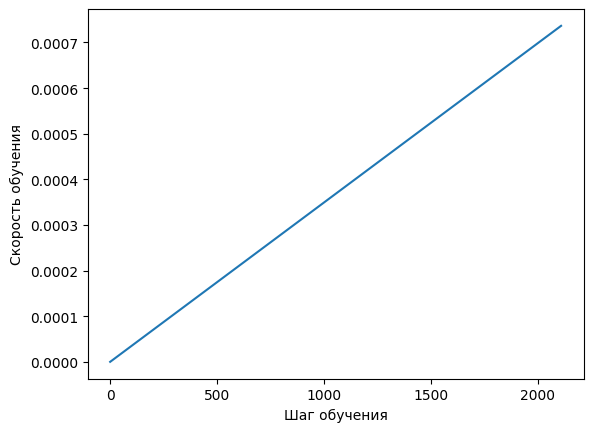

In [ ]:
plt.plot(learning_rate(tf.range(num_batches*EPOCHS, dtype=tf.float32)))
plt.ylabel('Скорость обучения')
plt.xlabel('Шаг обучения')

Лучшие результаты эта модель показала на 50 эпохах обучения, оно и понятно, для данного эксперимента график скорости обучения включает не только область "прогрева" и обучения с постоянным снижением скорости, что более логично.

Text(0.5, 0, 'Шаг обучения')

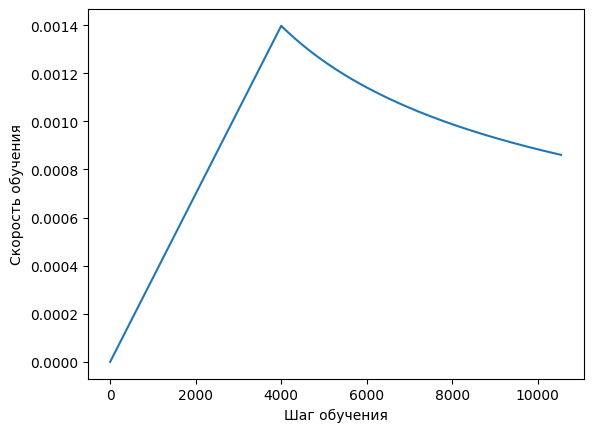

In [ ]:
plt.plot(learning_rate(tf.range(num_batches*EPOCHS*5, dtype=tf.float32)))
plt.ylabel('Скорость обучения')
plt.xlabel('Шаг обучения')

### Функция потерь и метрики

Поскольку целевые последовательности выровнены и заполнены нулями до конца последовательности, важно применять маску заполнения при расчете потерь.

В качестве функции потерь мы будем применять разряженную категориальную кросс-энтропию `tf.keras.losses.SparseCategoricalCrossentropy`:

In [ ]:
# Функция потерь с учетом маски
def masked_loss(label, pred):
  # Задаем маску, где метки не равны 0
  mask = label != 0
  # Определяем функцию потерь
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  # Важно чтобы mask и loss имели одинаковый тип данных
  mask = tf.cast(mask, dtype=loss.dtype)
  # Наложение маски на loss
  loss *= mask

  # Масштабирование потерь на маску
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

# Функция точности с учетом маски
def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  # Оценка совпадения метки и предсказания
  match = label == pred
  # Задаем маску, где метки не равны 0
  mask = label != 0

  # Логическое И
  match = match & mask

  # Преобразуем к одному типу и масштабирование совпадений на маску
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

### Компилируем и обучаем модель

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
transformer.fit(train_batches,
                epochs=EPOCHS,
                validation_data=val_batches)

Epoch 1/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 3605s 5s/step - loss: 8.1502 - masked_accuracy: 0.0481 - val_loss: 6.1960 - val_masked_accuracy: 0.1044
Epoch 2/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 3585s 5s/step - loss: 5.9925 - masked_accuracy: 0.1150 - val_loss: 5.5268 - val_masked_accuracy: 0.1325
Epoch 3/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 3588s 5s/step - loss: 5.3856 - masked_accuracy: 0.1417 - val_loss: 5.1883 - val_masked_accuracy: 0.1470


## Выполнение модели (Inference)

Теперь мы можем протестировать модель, для этого оформим класс QA, как модуль tensorflow:

In [ ]:
class QA(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):

    assert isinstance(sentence, tf.Tensor) # Проверяем, что последовательность является тензором
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.tokenize(sentence).to_tensor()
    # Введенное предложение написано на португальском языке
    encoder_input = sentence

    # Поскольку языком вывода является английский, инициализируйте вывод с помощью токена [START]
    start_end = self.tokenizers.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # Здесь требуется  tf.TensorArray` (вместо списка Python), чтобы динамический цикл
    # можно было отследить с помощью `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      # на каждом шаге складываем выходные токены в массив для
      #  передачи на вход на следующем шаге
      output = tf.transpose(output_array.stack())
      # передаем в трансформер для предсказания токены
      predictions = self.transformer([encoder_input, output], training=False)

      # Выбираем последний токен из измерения `seq_len`
      predictions = predictions[:, -1:, :]  # Форма `(batch_size, 1, vocab_size)`.

      # Предсказанный токен
      predicted_id = tf.argmax(predictions, axis=-1)

      # Объединяем `predicted_id` с выходными данными, которые передаются
      # декодеру в качестве входных данных.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # Токены в текст
    text = tokenizers.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.lookup(output)[0]

    # `tf.function` не позволяет нам использовать значения attention_weight, которые были
    # рассчитаны на последней итерации цикла.
    # Поэтому пересчитаем их вне цикла.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

Создадим экземпляр класса Translator и протестируем на нескольких фразах:

In [ ]:
qa_model = QA(tokenizers, transformer)

In [ ]:
def print_answer(sentence, tokens, ground_truth):
  print(f'{"Вопрос:":25s}: {sentence}')
  print(f'{"Предсказанный ответ:":25s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Оригинальный ответ":25s}: {ground_truth}')

In [ ]:
counter = 0
random_rows = val_df.sample(n=5)
for _, row in random_rows.iterrows():
    question_text = row['question']
    ground_truth = row['answer']
    answer_text, answer_tokens, attention_weights = qa_model(tf.constant(question_text))
    counter += 1
    print(f"Пример {counter}")
    print_answer(question_text, answer_text, ground_truth)
    print()

Пример 1
Вопрос:                  : вы в свой выходной куда выходите?
Предсказанный ответ:     : в стекром и верх . верх .
Оригинальный перевод     : в выходной спокойно выхожу. на кухню. а так обычно бегом.

Пример 2
Вопрос:                  : вы многое поняли? все во время или с опозданием?
Предсказанный ответ:     : я не люблю . но не люблю .
Оригинальный перевод     : я верю в судьбу, значит все вовремя, хотя вот лично я иногда думаю где глаза были и мозги

Пример 3
Вопрос:                  : мужчины, что вы делаете когда вам нравится девушка, но у нее слишком много тараканов в голове?
Предсказанный ответ:     : я не люблю . но не люблю .
Оригинальный перевод     : покупаю клетку. для этих тараканов.

Пример 4
Вопрос:                  : можно просто так посидеть в кафе?
Предсказанный ответ:     : да , я не люблю . но не верватив .
Оригинальный перевод     : можно, но заказать хоть корочку хлеба нужно обязательно

Пример 5
Вопрос:                  : малфой
Предсказанный ответ:     :

Ответы так себе, но кол-во эпох при обучении всего 3!

## График внимания

Создадим функцию внимания:

In [ ]:
def plot_attention_head(in_tokens, answer_tokens, attention):
  # Пропускаем токен `[START]`
  answer_tokens = answer_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(answer_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in answer_tokens.numpy()]
  ax.set_yticklabels(labels)

Нас интересует, например, внимание головы с индексом 0, на входе у нас оценки внимания `attention_weights`: с формой `(batch=1, num_heads, seq_len_q, seq_len_k)`.

In [ ]:
head = 0  # номер головы
# Форма attention_weights: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0) # убираем нулевое измерение тензора
attention = attention_heads[head] # выбираем нужную голову
attention.shape

TensorShape([18, 6])

Входная последовательность вопроса:

In [ ]:
in_tokens = tf.convert_to_tensor([question_text])
in_tokens = tokenizers.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.lookup(in_tokens)[0]

in_tokens_decoded = [token.decode('utf-8') for token in in_tokens.numpy()]
in_tokens_decoded

['[START]', 'м', '##ал', '##ф', '##ои', '[END]']

Выходной ответ:

In [ ]:
answer_tokens_decoded = [token.decode('utf-8') for token in answer_tokens.numpy()]
answer_tokens_decoded

['[START]',
 'а',
 'я',
 'не',
 'с',
 '##та',
 '##р',
 '##ба',
 ',',
 'а',
 'там',
 'и',
 'не',
 'с',
 '##та',
 '##р',
 '##ба',
 '##и',
 '[END]']

График внимания для 0 головы:

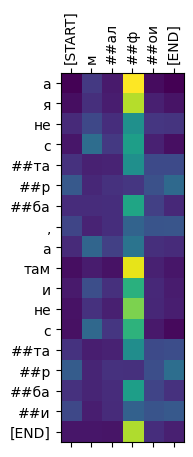

In [ ]:
plot_attention_head(in_tokens, answer_tokens, attention)

Можно вывести сразу в цикле для всех голов:

In [ ]:
def plot_attention_weights(sentence, answer_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, answer_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

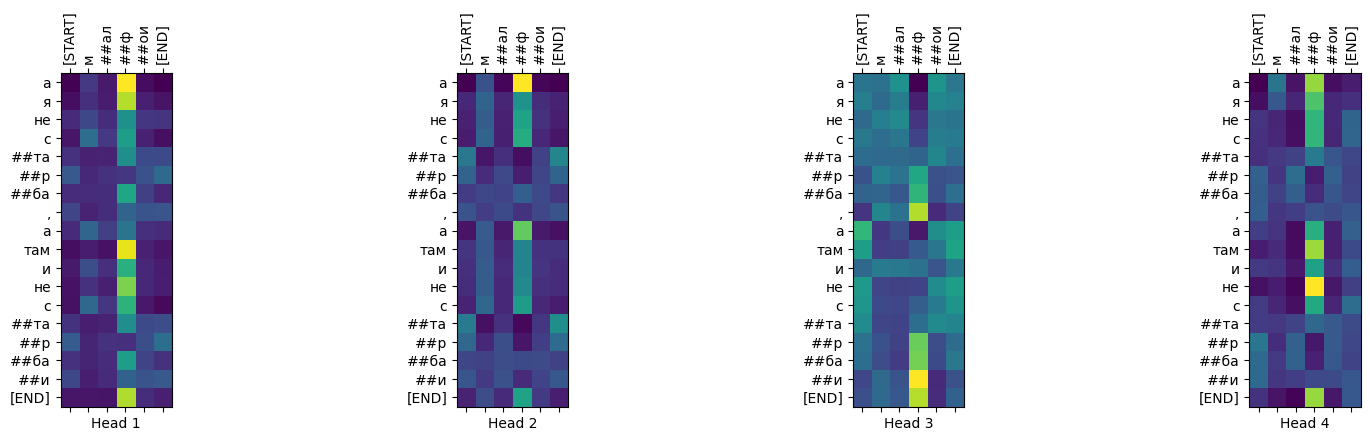

In [ ]:
plot_attention_weights(question_text,
                       answer_tokens,
                       attention_weights[0])

Как видно из тепловых карт: каждая голова работает по своему, все тепловые карты разные.

## Экспорт модели

Мы протестировали модель, она работает, выдает хорошие результаты, а значит надо ее сохранить и использовать в своих проектах.

Модель можно экспортировать как `tf.saved_model`. Чтобы узнать о сохранении и загрузке модели в формате `SavedModel`, воспользуйтесь [этим](https://www.tensorflow.org/guide/saved_model) руководством.

Приступим к созданию модуля. Для этого создадим класс с именем `ExportTranslator` и наследуем его от `tf.Module`:

In [ ]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

По факту наш новый модуль просто вызывает созданный ранее класс `Translator` в методе `__call__`, обернутой в `@tf.function`.

Переносим транслятор во вновь созданный ExportTranslator:

In [ ]:
qa_model = ExportTranslator(qa_model)

Поскольку модель декодирует прогнозы с использованием `tf.argmax`, прогнозы являются детерминированными. Исходная модель и модель, загруженная повторно из сохраненной модели, должны выдавать идентичные прогнозы, проверим это предположение:

In [ ]:
qa_model('как у тебя дела?').numpy().decode('utf-8')

'я не люблю , но я не люблю .'

Сохраняем модель в папку:

In [ ]:
tf.saved_model.save(qa_model, export_dir='qa_model')

Сохраняем модель из папки:

In [ ]:
reloaded = tf.saved_model.load('qa_model')

# Генерируем предсказание:

In [ ]:
reloaded('как у тебя дела?').numpy().decode('utf-8')

'я не люблю , но я не люблю .'